Trying to use guide https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [232]:
import sys 
import numpy as np # linear algebra
# from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
# import seaborn as sns # used for plot interactive graph. 
# from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
# from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline # pipeline making
# from sklearn.model_selection import cross_val_score
# from sklearn.feature_selection import SelectFromModel
# from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
from keras import backend as K
import keras
from keras.layers import Dense, Input
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools
from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation
import pickle
import os

## from REFIT tutorial
from lxml import objectify
%matplotlib inline

In [233]:
path=r'dataset/REFIT_BUILDING_SURVEY.xml'
tree = objectify.parse(path)
root = tree.getroot()
NS={'a':'http://www.refitsmarthomes.org'}

path=r'dataset/REFIT_TIME_SERIES_VALUES.csv'

cache = 'csv.pkl'

if os.path.isfile(cache):
    with open(cache, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        csv = pickle.load(f)
else:
    try:
        csv
    except:
        csv=pd.read_csv(path, index_col=0, parse_dates=[1])
    with open(cache, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(csv, f, pickle.HIGHEST_PROTOCOL)
    
    
    
## Global parameters
building_num = 1

In [234]:
## Get climate data
elements=root.xpath('./a:Stock/a:Climate/a:Sensor/a:TimeSeriesVariable', namespaces=NS)
data_clim = {}
time_clim = []
agg = {}
period = 'H'

for e in elements:
    id = e.get('id')
    v = csv.loc[id]
    sensor_name = e.get('variableType').replace(' ', '_')
    if len(time_clim) < 1:
        time_clim = v['dateTime'].tolist() 
    if sensor_name == 'Total_rainfall':
        tmp = np.sum
    else:
        tmp = np.mean
    agg[sensor_name] = tmp
    data_clim[sensor_name] = v['data'].tolist()
climdf = pd.DataFrame(data_clim, index=time_clim).resample(period).agg(agg)
##clean climdf (only when not resamplet for Day 'D')
#climdf = climdf.iloc[1::2] ## Some timeSteps are not in gas_meter indexes (15 mins and 45 mins values, 00 and 30 mins are in)

    
## Get gas meter data
appliance    = 1 #Number of gas meter
tsv = root.xpath('./a:Stock/a:Building[%d]/a:Meter[%d]/a:Sensor/a:TimeSeriesVariable' % (building_num, appliance), namespaces=NS)
id = tsv[0].get('id')
gasdf = csv.loc[id]
data_gas = {'gas': gasdf['data'].tolist()}
time_gas = gasdf['dateTime'].tolist()
gasdf = pd.DataFrame(data_gas, index=time_gas).resample(period).sum()
agg['gas'] = np.sum

## Merge two DataFrames gas meter and weather
df = pd.concat([climdf, gasdf], axis=1)
df.index.name = 'time'
## clean rows
df = df[np.isfinite(df['Air_temperature'])]   # We don't need data where no weather forecast
lastind = time_gas[-1]
df = df[:lastind]                             # We don't need data where no meter values


## NaN rows detection
j = len(df.columns) - 1 # last column is 'gas'
df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Air_temperature                        0
Relative_humidity                      0
Wind_speed                             0
Wind_direction_D1                      0
Wind_direction_SD1                     0
Average_horizontal_solar_irradiance    0
Total_horizontal_solar_irradiation     0
NR_Wm2_Avg                             0
CNR_Wm2_Avg                            0
Total_rainfall                         0
Average_barometric_pressure            0
gas                                    0
dtype: int64

In [235]:
df['Wind_speed'].argmax()

C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


Timestamp('2014-08-25 22:00:00', freq='H')

In [236]:
df.describe()

,Air_temperature,Relative_humidity,Wind_speed,Wind_direction_D1,Wind_direction_SD1,Average_horizontal_solar_irradiance,Total_horizontal_solar_irradiation,NR_Wm2_Avg,CNR_Wm2_Avg,Total_rainfall,Average_barometric_pressure,gas
count,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.00000,13167.000000,13167.000000,13167.000000
mean,9.862965,80.878419,1.688931,201.652367,35.285495,0.091155,0.821077,20.826535,20.84122,0.083041,1005.985216,0.152679
std,5.439630,12.376633,10.423738,78.820119,15.357090,0.159151,1.431899,105.405726,105.65288,0.390869,12.655515,0.208213
min,-3.576750,29.912500,0.127500,5.234750,9.733500,0.000000,0.000754,-180.465000,-188.00000,0.000000,960.000000,0.000000
25%,5.762500,74.717500,0.859750,136.962500,23.978750,0.000000,0.001492,-42.651250,-42.69125,0.000000,998.000000,0.000000
50%,9.132500,83.950000,1.380000,224.650000,31.240000,0.001750,0.015682,-14.747750,-14.78250,0.000000,1007.000000,0.000000
75%,13.511250,90.300000,2.020250,268.850000,42.427500,0.108750,0.979007,30.880000,30.88000,0.000000,1015.000000,0.340000
max,30.897500,97.800000,880.775000,353.750000,98.275000,0.856000,7.703240,551.475000,709.19750,16.200000,1034.000000,1.270000


In [237]:
df.head()

,Air_temperature,Relative_humidity,Wind_speed,Wind_direction_D1,Wind_direction_SD1,Average_horizontal_solar_irradiance,Total_horizontal_solar_irradiation,NR_Wm2_Avg,CNR_Wm2_Avg,Total_rainfall,Average_barometric_pressure,gas
time,,,,,,,,,,,,
2013-11-04 09:00:00,5.777333,78.066667,1.90200,286.466667,21.726667,0.066667,0.458153,-64.273333,-64.273333,0.0,984.333333,0.54
2013-11-04 10:00:00,7.186000,73.962500,2.13525,284.150000,23.452500,0.252250,2.270645,50.895000,50.897500,0.0,985.250000,0.04
2013-11-04 11:00:00,8.450000,72.830000,2.33425,283.325000,27.000000,0.321250,2.891341,125.150000,125.150000,0.0,986.000000,0.00
2013-11-04 12:00:00,9.522500,65.207500,3.07175,286.350000,24.722500,0.325500,2.928205,165.600000,165.725000,0.0,986.000000,0.00
2013-11-04 13:00:00,9.852500,65.977500,3.54825,290.075000,23.997500,0.279750,2.520264,119.350000,119.750000,0.0,986.250000,0.00


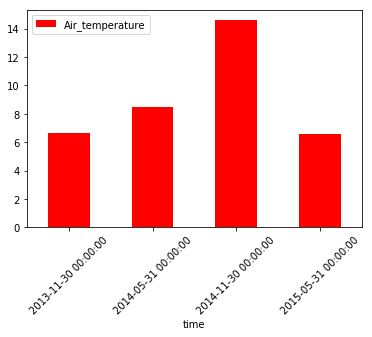

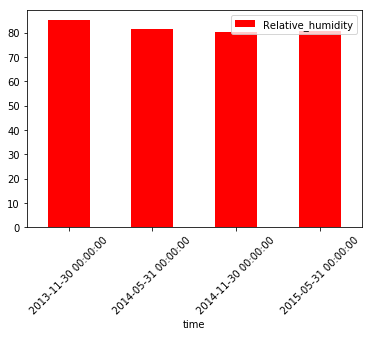

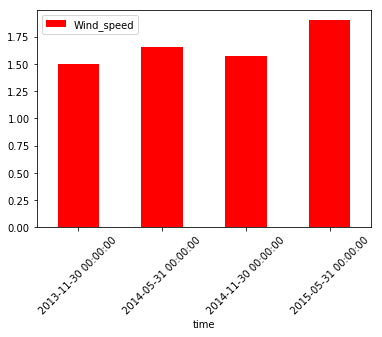

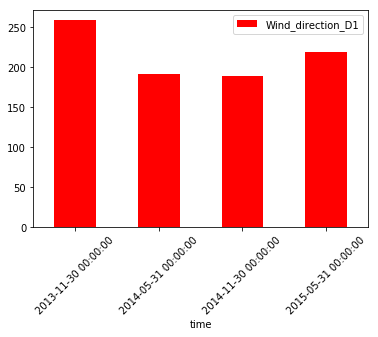

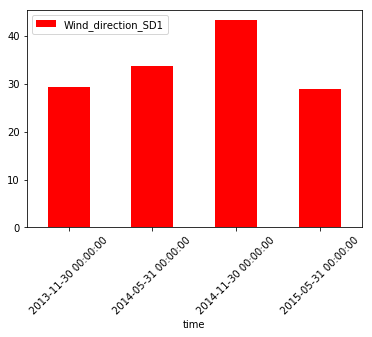

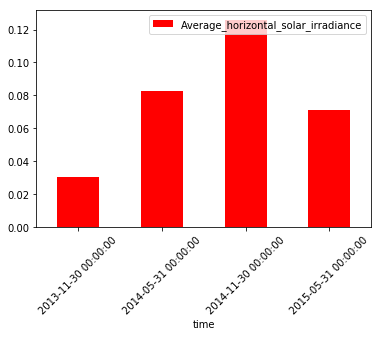

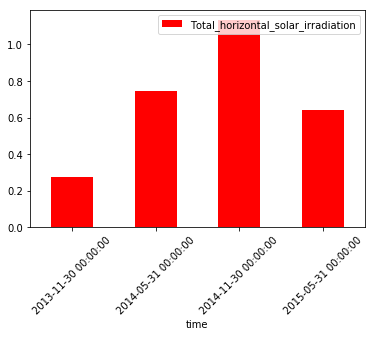

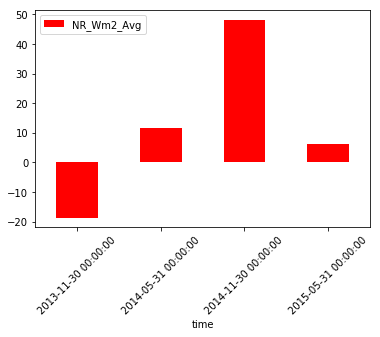

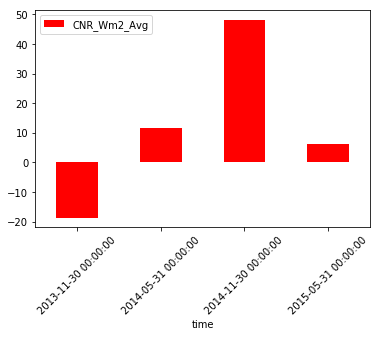

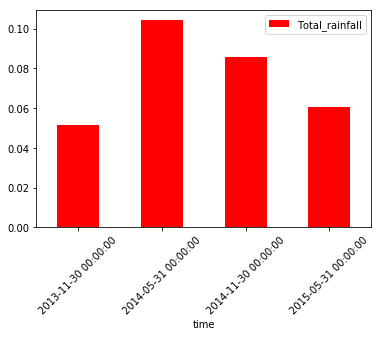

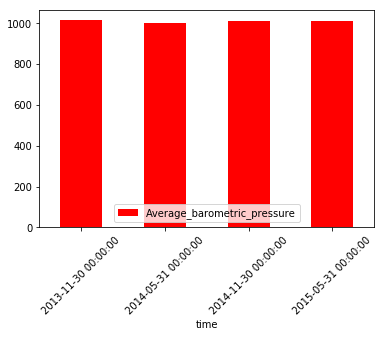

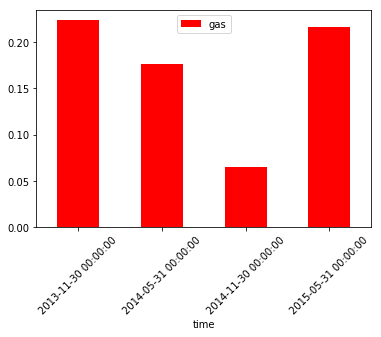

In [238]:
cols = list(range(len(df.columns)))
i = 1

tmp = pd.DataFrame(df.resample('6M').mean())

for col in tmp.columns:
    tmp[col].plot(kind='bar', color='r', legend=True )
    plt.xticks(rotation=45)
    plt.show()

## convert illuminance values 

C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.
C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  import sys
C:\Users\Ford\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


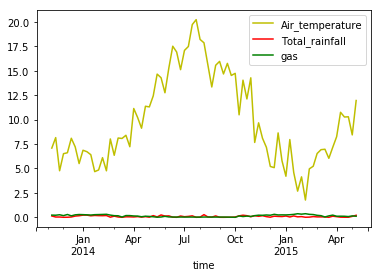

In [239]:
period = 'W' ## M, Q, W, A == Year

## resampling over week and computing mean
df.Air_temperature.resample(period).plot(color='y', legend=True)
# df.Average_barometric_pressure.resample(period).mean().plot(color='r', legend=True)
# df.Relative_humidity.resample(period).mean().plot(color='b', legend=True)
df.Total_rainfall.resample(period).plot(color='r', legend=True)
# df.Wind_speed.resample(period).plot(color='b', legend=True)
df.gas.resample(period).plot(color='g', legend=True)
plt.show()

0: Air_temperature
1: Relative_humidity
2: Wind_speed
3: Wind_direction_D1
4: Wind_direction_SD1
5: Average_horizontal_solar_irradiance
6: Total_horizontal_solar_irradiation
7: NR_Wm2_Avg
8: CNR_Wm2_Avg
9: Total_rainfall
10: Average_barometric_pressure
11: gas


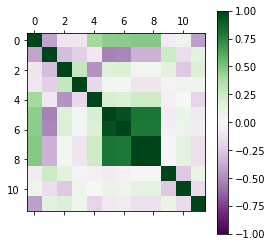

In [240]:
def pltCor(df):
    print('\n'.join(['%d: %s' % (i, j) for i, j in enumerate(df.columns.tolist())]))
    # Correlations among columns
    plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.colorbar()
    plt.show()

pltCor(df)

0: Air_temperature
1: Relative_humidity
2: Wind_speed
3: Wind_direction_D1
4: Wind_direction_SD1
5: Average_horizontal_solar_irradiance
6: Total_horizontal_solar_irradiation
7: NR_Wm2_Avg
8: CNR_Wm2_Avg
9: Total_rainfall
10: Average_barometric_pressure
11: gas


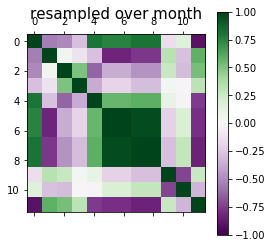

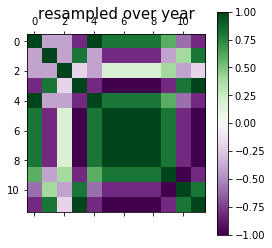

In [241]:
# Correlations of mean of features resampled over months

print('\n'.join(['%d: %s' % (i, j) for i, j in enumerate(df.columns.tolist())]))

plt.matshow(df.resample('W').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('6M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

## Start to prepare data and build model

In [242]:
df_resample = df.resample('D').agg(agg)
df_resample.shape

(549, 12)

In [243]:
kqk = df_resample.index.to_period('M').start_time.unique()[1:]
# print(kqk)

kqk = [df_resample.index.get_loc(i) for i in kqk]
kqk.insert(0,0)
kqk[-1] = df_resample.shape[0]
print('-'.join(map(str,kqk)))

0-27-58-89-117-148-178-209-239-270-301-331-362-392-423-454-482-513-549


In [244]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [(data.columns[j] + ' (t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [(data.columns[j] + ' (t)') for j in range(n_vars)]
        else:
            names += [(data.columns[j] + ' (t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
    return agg

In [245]:
dow = df_resample.index.dayofweek.values
doy = df_resample.index.dayofyear.values

0: doy
1: dow
2: Air_temperature (t-3)
3: Average_horizontal_solar_irradiance (t-3)
4: Total_horizontal_solar_irradiation (t-3)
5: NR_Wm2_Avg (t-3)
6: CNR_Wm2_Avg (t-3)
7: gas (t-3)
8: Air_temperature (t-2)
9: Average_horizontal_solar_irradiance (t-2)
10: Total_horizontal_solar_irradiation (t-2)
11: NR_Wm2_Avg (t-2)
12: CNR_Wm2_Avg (t-2)
13: gas (t-2)
14: Air_temperature (t-1)
15: Average_horizontal_solar_irradiance (t-1)
16: Total_horizontal_solar_irradiation (t-1)
17: NR_Wm2_Avg (t-1)
18: CNR_Wm2_Avg (t-1)
19: gas (t-1)
20: Air_temperature (t)
21: Average_horizontal_solar_irradiance (t)
22: Total_horizontal_solar_irradiation (t)
23: NR_Wm2_Avg (t)
24: CNR_Wm2_Avg (t)
25: gas (t)


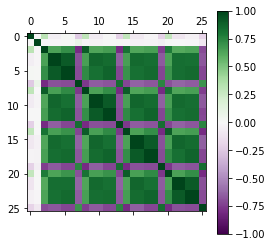

Shape is:  (546, 26)


In [246]:
# frame as supervised learning
look_back = 3
reframed = series_to_supervised(df_resample, look_back, 1)


# drop columns we don't want to predict
predName = 'gas (t)'
tmp = reframed.corr(method='spearman')[predName]
del tmp[predName]

reframed.insert(loc=0, column='dow', value=dow)
reframed.insert(loc=0, column='doy', value=doy)

reframed.dropna(inplace=True)

#Select features with relevat correlation
corLev = 0.6
tmp = tmp.loc[tmp.abs() < corLev].index.tolist()
kek = list(map(reframed.columns.get_loc, tmp))
reframed.drop(reframed.columns[kek], axis=1, inplace=True)

pltCor(reframed)
print('Shape is: ', reframed.shape)

In [247]:
predNamepredName = 'gas (t)'
tmp = reframed.corr(method='spearman')[predName]
del tmp[predName]

tmp
# tmp = tmp.loc[tmp.abs() > 0.5].index.tolist()

doy                                         -0.202379
dow                                         -0.085301
Air_temperature (t-3)                       -0.700023
Average_horizontal_solar_irradiance (t-3)   -0.668847
Total_horizontal_solar_irradiation (t-3)    -0.668685
NR_Wm2_Avg (t-3)                            -0.716293
CNR_Wm2_Avg (t-3)                           -0.714826
gas (t-3)                                    0.691605
Air_temperature (t-2)                       -0.737078
Average_horizontal_solar_irradiance (t-2)   -0.659675
Total_horizontal_solar_irradiation (t-2)    -0.659592
NR_Wm2_Avg (t-2)                            -0.712374
CNR_Wm2_Avg (t-2)                           -0.710615
gas (t-2)                                    0.746267
Air_temperature (t-1)                       -0.790171
Average_horizontal_solar_irradiance (t-1)   -0.645318
Total_horizontal_solar_irradiation (t-1)    -0.645299
NR_Wm2_Avg (t-1)                            -0.712513
CNR_Wm2_Avg (t-1)           

In [248]:
## Scale data to (0..1) values range## Scale 
values = reframed.values

X,Y = values[:, :-1], values[:, -1]
scalerX = MinMaxScaler(feature_range=(0, 1))
X = scalerX.fit_transform(X)
scalerY = MinMaxScaler(feature_range=(0, 1))
Y = scalerY.fit_transform(Y.reshape(-1, 1))

In [249]:
print(X.shape)
print(Y.shape)
assert Y.shape[0] == X.shape[0]

(546, 25)
(546, 1)


In [250]:
comp = min(17, X.shape[1])

pca = PCA(n_components=comp) #PCA(0.1) #

X = pca.fit_transform(X=X) 

# to get how much variance was retained
print(pca.explained_variance_ratio_.sum())
print(X.shape)

0.9999635159571375
(546, 17)


In [251]:
## Split into train and test sets
n_train_time = int(reframed.shape[0] * 0.85)
train_X, train_y = X[:n_train_time, :], Y[:n_train_time, :]
test_X, test_y   = X[n_train_time:, :], Y[n_train_time:, :]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(464, 1, 17) (464, 1) (82, 1, 17) (82, 1)


In [252]:
import random
random.seed(42)

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
# model.add(Dense(70))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=7, validation_data=(test_X, test_y), verbose=1, shuffle=False)



Train on 464 samples, validate on 82 samples
Epoch 1/30
464/464 [==============================] - 7s 15ms/step - loss: 0.0891 - val_loss: 0.0486
Epoch 2/30
464/464 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0260
Epoch 3/30
464/464 [==============================] - 1s 1ms/step - loss: 0.0134 - val_loss: 0.0240
Epoch 4/30
464/464 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0232
Epoch 5/30
464/464 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0230
Epoch 6/30
464/464 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0227
Epoch 7/30
464/464 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0226
Epoch 8/30
464/464 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0226
Epoch 9/30
464/464 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0227
Epoch 10/30
464/464 [==============================] -

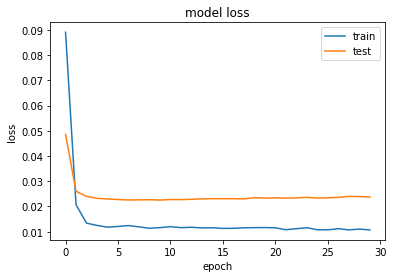

Test RMSE: 1.814


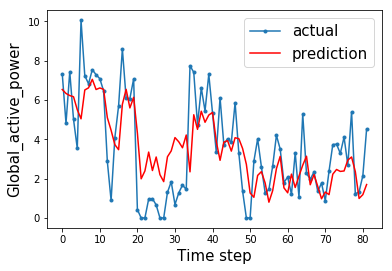

In [253]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# make a prediction
yhat = model.predict(test_X, batch_size=7)
# invert scaling for forecast
inv_yhat = scalerY.inverse_transform(yhat)
# invert scaling for actual
inv_y = scalerY.inverse_transform(test_y)


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


interval = min(len(test_y), 100)
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 
aa=[x for x in range(interval)]
plt.plot(aa, inv_y[:interval], marker='.', label="actual")
plt.plot(aa, inv_yhat[:interval], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [254]:
pred = model.predict(X.reshape((X.shape[0], 1, X.shape[1])))

In [255]:
data = []
time = []

yy = scalerY.inverse_transform(Y)
ypred = scalerY.inverse_transform(pred)
ypred = np.array([i if i >= 0.0 else 0.0 for i in ypred]).reshape(-1,1)

for k in range(len(kqk)-1):
    data.append(np.sqrt(mean_squared_error(yy[kqk[k]:kqk[k+1]], ypred[kqk[k]:kqk[k+1]])))
    time.append(df_resample.index[kqk[k]])
    
rmse = np.sqrt(mean_squared_error(yy, ypred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.279


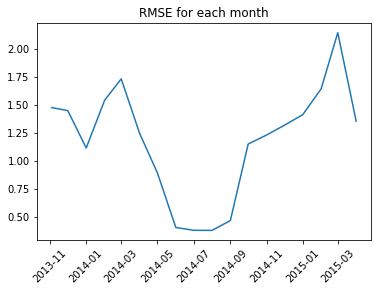

In [256]:
plt.plot(time, data)
plt.title("RMSE for each month")
plt.xticks(rotation=45)
plt.show()

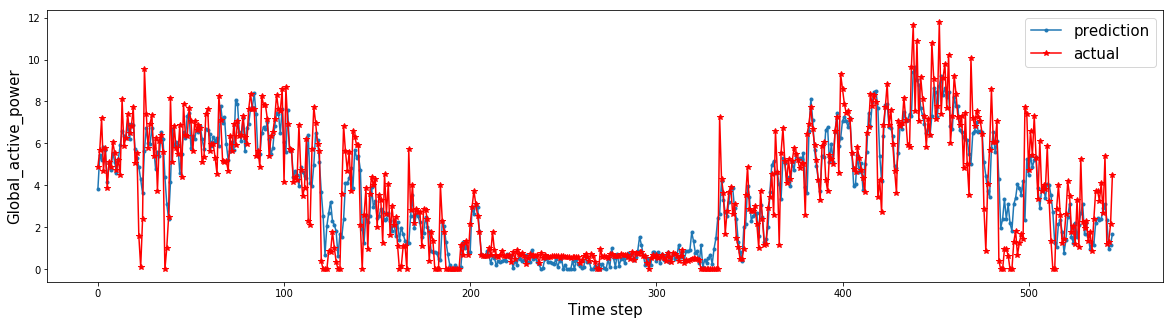

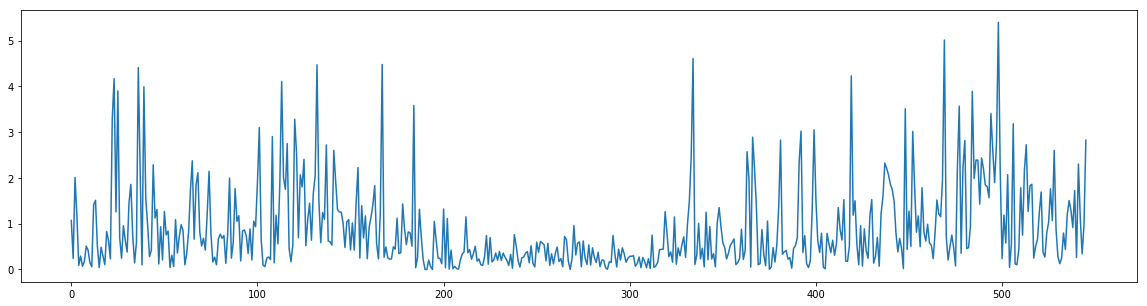

In [257]:
begin = 0
end = yy.shape[0]

aa = list(range(begin, end))
plt.figure(figsize=(20, 5))
plt.plot(aa,ypred[begin:end], marker='.', label="prediction")
plt.plot(aa,yy[begin:end],'r', marker='*', label="actual")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


kak = [abs((ypred[i] - yy[i])) for i in range(begin, end)]
plt.figure(figsize=(20, 5))
plt.plot(aa, kak)
plt.show()

In [258]:
# import shelve
# db = shelve.open("brute_PCA_dim.pkl")
# db['data'] = data
# db.close()

In [259]:
# plt.plot(list(range(30,80,5)), data)
# plt.show()

# предсказывает отрицательные величины

# pca
# Автокорреляция
# попробовать из статейки
# predict season
# Other topology (LSTM at least)
# Добавить день недели, месяц, число, часы в инпуты

#Предсказывать потребление для района, а не для одной семьи/дома!






# Посчитать данные:
# в каком месяце наибольшая ошибка для всех домов (тот месяц будет наиболее активным, когда потребление наиболее нерпедсказуемо?)
# собрать данные: ошибка всей выборки, тренировочной выборки для каждого дома, мат ожидание для каждого дома. Как эти данные соотносятся?
# 